# Выбор локации для скважины

Компания «ГлавРосГосНефть». Необходимо решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Задача – построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy import stats as st
import warnings
warnings.simplefilter('ignore')

In [5]:
df1 = pd.read_csv('geo_data_0.csv')
df2 = pd.read_csv('geo_data_1.csv')
df3 = pd.read_csv('geo_data_2.csv')

Выведем основную информацию о датафреймах

In [6]:
df1.info(),
print('---'*10),
df1.info(),
print('---'*10),
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to

Во всех датафреймах 1000 строк без пропусков и 4 колонки

Проверим датафреймы на наличие полных дубликатов

In [7]:
(
df1.duplicated().sum(),
df2.duplicated().sum(),
df3.duplicated().sum()
)

(0, 0, 0)

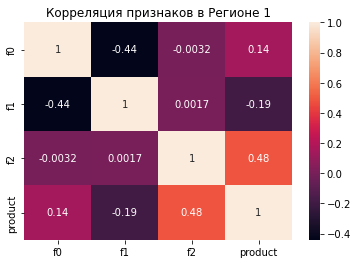

In [8]:
sns.heatmap(df1.corr(), annot=True)
plt.title('Корреляция признаков в Регионе 1');

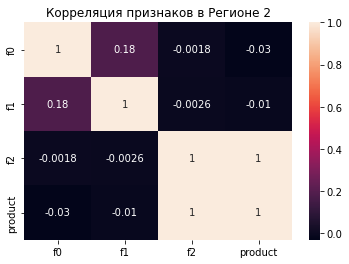

In [9]:
sns.heatmap(df2.corr(), annot=True);
plt.title('Корреляция признаков в Регионе 2');

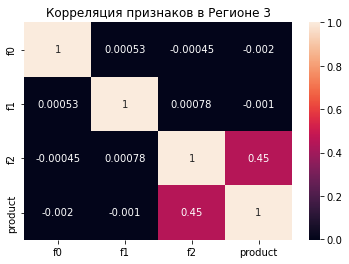

In [10]:
sns.heatmap(df3.corr(), annot=True);
plt.title('Корреляция признаков в Регионе 3');

**Вывод**:<br>
Данные загружены. Во всех трёх датафреймах нет пропусков и нет дубликатов. Один признак из пяти имеющихся является строковым типом (id), остальные – float. В сете второго региона обнаружена полная корреляция между признаками `product` и `f2`, что может негативно сказаться на использовании линейных моделей, однако, как сказано в условии, данные признаки являются важными, а значит, смело строим модель 

## Обучение и проверка модели

Объявим переменные с предсказаниями и правильными ответами для каждого региона

In [11]:
model = LinearRegression()
scaler = MinMaxScaler()

# Циклом объявим небходимые переменные и заполним их соответствующими значениями
for df, i in [(df1, 1), (df2, 2), (df3, 3)]:

    features = scaler.fit_transform(df.drop(columns=['product', 'id'], axis=1))
    target = df['product']

    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.25, random_state=123)

    model.fit(features_train, target_train)
    
    if i == 1:
        region_1_model_predicted = model.predict(features_valid)
        region_1_target_valid = target_valid
    elif i == 2:
        region_2_model_predicted = model.predict(features_valid)
        region_2_target_valid = target_valid
    elif i == 3:
        region_3_model_predicted = model.predict(features_valid)
        region_3_target_valid = target_valid

Предскажем средний запас сырья и выведем `RMSE` модели каждого региона

In [12]:
# Объявим функцию по предсказанию значений и выводу RMSE
def predict_n_rmse(model_predicted, target_valid):
    mse = mean_squared_error(target_valid, model_predicted)
    print(f'Средний запас предсказанного сырья: {model_predicted.mean()}')
    print(f'RMSE модели:', mse ** .5)

In [13]:
print('регион 1'),
predict_n_rmse(region_1_model_predicted, region_1_target_valid),
print('---'*18),
print('регион 2'),
predict_n_rmse(region_2_model_predicted, region_2_target_valid),
print('---'*18),
print('регион 3'),
predict_n_rmse(region_3_model_predicted, region_3_target_valid)

регион 1
Средний запас предсказанного сырья: 92.54936189116304
RMSE модели: 37.64786282376176
------------------------------------------------------
регион 2
Средний запас предсказанного сырья: 69.28001860653903
RMSE модели: 0.8954139804944261
------------------------------------------------------
регион 3
Средний запас предсказанного сырья: 95.09859933591426
RMSE модели: 40.12803006598515


**Вывод**:<br>
Регион 2 по обоим показателям резко отличается от регионов 1 и 3. Очевидно предположить, что предсказанное среднее коррелирует с корнем среднеквадратической ошибки. Значит, в датасете второго региона меньший разброс данных

## Подготовка к расчёту прибыли

Объявим константы и рассчитаем объём сырья для безубыточной разработки

In [14]:
BUDGET = 10000000000 # бюджет
BEST = 200 # количество отбираемых лучших скважин
COST_BARREL = 450000 # доход с единицы продукта
BREAK_EVEN = round(BUDGET / BEST / COST_BARREL, 2)

BREAK_EVEN

111.11

In [15]:
print('регион 1'),
print('Средний запас:', df1['product'].mean()),
print('---'*18),
print('регион 2'),
print('Средний запас:', df2['product'].mean()),
print('---'*18),
print('регион 3'),
print('Средний запас:', df3['product'].mean())

регион 1
Средний запас: 92.49999999999974
------------------------------------------------------
регион 2
Средний запас: 68.82500000002561
------------------------------------------------------
регион 3
Средний запас: 95.00000000000041


**Вывод**:<br>
Средние запасы всех трёх регионов недостают до показателя безубыточности 111.11

## Расчёт прибыли и рисков 

Объявим датафреймы с 200 лучшими скважинами по предсказанным объёмам сырья

In [16]:
def create_pred_data(pred_target, target_valid, data):
    series = pd.Series(pred_target, index=target_valid.index).sort_values(ascending=False)[:BEST]
    boreholes = data.iloc[series.index]
    boreholes['predict_product'] = series
    return boreholes['predict_product'].sum() * COST_BARREL - BUDGET

In [17]:
best_boreholes_1 = create_pred_data(region_1_model_predicted, region_1_target_valid, df1)
best_boreholes_2 = create_pred_data(region_2_model_predicted, region_2_target_valid, df2)
best_boreholes_3 = create_pred_data(region_3_model_predicted, region_3_target_valid, df3)

Вычислим их прибыль

In [18]:
profit_1 = best_boreholes_1
profit_2 = best_boreholes_2
profit_3 = best_boreholes_3

In [19]:
print('Суммарная прибыль лучших скважин Региона 1'),
print(profit_1),
print('---'*6),
print('Суммарная прибыль лучших скважин Региона 2'),
print(profit_2),
print('---'*6),
print('Суммарная прибыль лучших скважин Региона 3'),
print(profit_3)

Суммарная прибыль лучших скважин Региона 1
3965654512.2921047
------------------
Суммарная прибыль лучших скважин Региона 2
2490092892.25721
------------------
Суммарная прибыль лучших скважин Региона 3
3474549399.676346


Сформируем выборки с тренировочными и тестовыми данными для каждого региона

In [20]:
model = LinearRegression()

features_1 = df1.drop(columns=['id', 'product'], axis=1)
target_1 = df1['product']
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=.25, random_state=123)
model.fit(features_train_1, target_train_1)
pred_1 = model.predict(features_valid_1)

features_2 = df2.drop(columns=['id', 'product'], axis=1)
target_2 = df2['product']
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=.25, random_state=123)
model.fit(features_train_2, target_train_2)
pred_2 = model.predict(features_valid_2)

features_3 = df3.drop(columns=['id', 'product'], axis=1)
target_3 = df3['product']
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(features_3, target_3, test_size=.25, random_state=123)
model.fit(features_train_3, target_train_3)
pred_3 = model.predict(features_valid_3) 

Техникой бутстреп сгенерируем подвыборки для вычислений профита со скважин каждого региона 

In [21]:
results_frame = pd.DataFrame(columns=['region', 'mean', 'risk', 'interval'])

def profit(y, predictions):
    predictions_sorted = pd.Series(predictions).reset_index(drop=True).sort_values(ascending=False)
    real_y = y.reset_index(drop=True).iloc[predictions_sorted.index][:BEST]  
    return real_y.sum() * COST_BARREL - BUDGET


state = np.random.RandomState(12345)
def bootstrap(target_valid, pred_valid, num):
    count = 0 
    values = []
    for i in range(1000):
        target_subsample = target_valid.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        predictions_subsample = pred_valid[target_subsample.index]
        value = profit(target_subsample, predictions_subsample)
        values.append(value)
        if value < 0:
            count += 1    
    
    values = pd.Series(values)
    
    results_frame.loc[num, ['region']] = [f'region_{num}']
    results_frame.loc[num,['mean']] = [round(values.mean(), 2)]
    results_frame.loc[num,['risk']] = [count/1000 * 100]  
    results_frame.loc[num,['interval']] = [(round(values.quantile(0.025), 2), round(values.quantile(0.975), 2))]
                                                
    return values

bootstrap(target_valid_1, pred_1, 1)
bootstrap(target_valid_2, pred_2, 2)
bootstrap(target_valid_3, pred_3, 3)

0      3.215619e+08
1      1.762222e+08
2      5.455041e+08
3      5.445529e+08
4      2.139449e+08
           ...     
995    3.720534e+08
996    4.192241e+08
997    7.219429e+08
998    7.750075e+08
999    2.571766e+08
Length: 1000, dtype: float64

In [22]:
results_frame

,region,mean,risk,interval
1,region_1,476303229.42,2.5,"(4800799.0, 1008423976.11)"
2,region_2,473858889.2,0.8,"(73182118.81, 869518807.65)"
3,region_3,348173477.35,10.6,"(-193079581.94, 848923140.65)"


**ВЫВОД**:<br>
По результатам проведённого анализа наиболее подходящим регионом с точки зрения бюджетирования скважин является регион 2. Именно на данных этого датасета мы получили ранее наименьшее RMSE и именно у этого региона наименьший риск и наиболее точный доверительный интервал